In [28]:
%load_ext dotenv
%dotenv ../.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [95]:
import tinvest
from datetime import datetime, timedelta
import pandas as pd
import os

def get_candles(
  company,
  interval=tinvest.CandleResolution.min1,
  periods=3,
):
  token = os.environ['TINKOFF_SECRET']
  client = tinvest.SyncClient(
    token,
    use_sandbox=False,
  )

  figi = company["figi"]
  ticker = company["ticker"]

  end_date = datetime.now()
  periods_with_candles = 0
  df = pd.DataFrame()
  delta = timedelta(days=1)
  if interval == tinvest.CandleResolution.hour:
      delta = timedelta(weeks=1)
  elif interval in [
      tinvest.CandleResolution.day,
      tinvest.CandleResolution.week,
      tinvest.CandleResolution.month,
  ]:
      delta = timedelta(years=1)

  while periods_with_candles < periods:
      start_date = end_date - delta

      print(
          f"[Tinkoff] Downloading candles for {ticker} {periods_with_candles}/{periods}"  # noqa
      )
      response = client.get_market_candles(
          figi,
          from_=start_date,
          to=end_date,
          interval=interval,
      )

      payload = response.payload

      if len(payload.candles) > 0:
          df = pd.concat(
              [
                  pd.DataFrame(
                      {
                          "Volume": float(c.dict()["v"]),
                          "High": float(c.dict()["h"]),
                          "Low": float(c.dict()["l"]),
                          "Open": float(c.dict()["o"]),
                          "Close": float(c.dict()["c"]),
                          "Date": c.dict()["time"] + timedelta(hours=3),
                      }
                      for c in payload.candles
                  ),
                  df,
              ],
              ignore_index=True,
          )
          periods_with_candles += 1

      end_date = start_date

  df.set_index("Date", inplace=True)

  # remove duplicates
  df = df[~df.index.duplicated(keep="last")]

  print(
      f"[Tinkoff] Candles for {ticker} successfully downloaded!",  # noqa
  )

  return df, figi


periods = 40
interval=tinvest.CandleResolution.min15
companies = [
  { "figi": 'BBG003PHHZT1', "ticker": "MRNA"},
  { "figi": 'BBG000N9MNX3', "ticker": "TSLA" },
  { "figi": 'BBG000BBJQV0', "ticker": "NVDA" },
]

def download():
  result = {}
  for company in companies:
    result[company['figi']] = get_candles(company, interval=interval, periods=periods)
  
  return result

result = download()


[Tinkoff] Downloading candles for MRNA 0/40
[Tinkoff] Downloading candles for MRNA 1/40
[Tinkoff] Downloading candles for MRNA 2/40
[Tinkoff] Downloading candles for MRNA 3/40
[Tinkoff] Downloading candles for MRNA 4/40
[Tinkoff] Downloading candles for MRNA 5/40
[Tinkoff] Downloading candles for MRNA 6/40
[Tinkoff] Downloading candles for MRNA 7/40
[Tinkoff] Downloading candles for MRNA 8/40
[Tinkoff] Downloading candles for MRNA 9/40
[Tinkoff] Downloading candles for MRNA 10/40
[Tinkoff] Downloading candles for MRNA 11/40
[Tinkoff] Downloading candles for MRNA 12/40
[Tinkoff] Downloading candles for MRNA 13/40
[Tinkoff] Downloading candles for MRNA 14/40
[Tinkoff] Downloading candles for MRNA 15/40
[Tinkoff] Downloading candles for MRNA 16/40
[Tinkoff] Downloading candles for MRNA 17/40
[Tinkoff] Downloading candles for MRNA 18/40
[Tinkoff] Downloading candles for MRNA 19/40
[Tinkoff] Downloading candles for MRNA 20/40
[Tinkoff] Downloading candles for MRNA 21/40
[Tinkoff] Downloadin

In [96]:
# find out previous run ups

import arrow
import pandas_ta

trades = {}

for company in companies:
    figi = company["figi"]
    ticker = company["ticker"] 

    (candles, _) = result[figi]
    indicator_result = candles.ta.squeeze(lazybear=True)

    index = 0
    trades[figi] = []

    for (date, indicator_value) in zip(indicator_result.index, indicator_result['SQZ_20_2.0_20_1.5_LB']):
      close = candles.at[date, 'Close']
      high = candles.at[date, 'High']
      low = candles.at[date, 'Low']

      is_sell = False
      is_buy = False

      if index == 0:
        index += 1
        continue

      # without squeeze
      # if (
      #     indicator_value > 0
      #     and indicator_result['SQZ_20_2.0_20_1.5_LB'][index - 1] <= 0
      # ):
      #     is_buy = True
      # elif (
      #     indicator_value < 0
      #     and indicator_result['SQZ_20_2.0_20_1.5_LB'][index - 1] >= 0
      # ):
      #     is_sell = True
      
      # squeeze

      is_buy_stop = False
      is_sell_stop = False

      if (
          indicator_result['SQZ_ON'][index] == 0 and
          indicator_result['SQZ_ON'][index - 1] == 1 and
          indicator_value > 0 and
          indicator_value > indicator_result['SQZ_20_2.0_20_1.5_LB'][index - 1]
      ):
          is_buy = True
      elif (
          indicator_result['SQZ_ON'][index] == 0 and
          indicator_result['SQZ_ON'][index - 1] == 1 and
          indicator_value < 0 and
          indicator_value < indicator_result['SQZ_20_2.0_20_1.5_LB'][index - 1]
      ):
          is_sell = True

      if (
          indicator_value > 0
          and indicator_result['SQZ_20_2.0_20_1.5_LB'][index - 1] <= 0
      ):
          is_sell_stop = True
      elif (
          indicator_value < 0
          and indicator_result['SQZ_20_2.0_20_1.5_LB'][index - 1] >= 0
      ):
          is_buy_stop = True

      last_trade = trades[figi][-1] if len(trades[figi]) > 0 else False
      local_date = arrow.get(date)

      # squeeze stop

      if is_sell_stop or is_buy_stop:
        if last_trade:
          one_percent = last_trade['price_in'] / 100
          last_trade['price_out'] = close
          last_trade['time_out'] = local_date
          last_trade['profit'] = ((last_trade['price_in'] - last_trade['price_out']) / one_percent) if last_trade['type'] == 'short' else (last_trade['price_out'] - last_trade['price_in']) / one_percent
          last_trade['run_up'] = ((last_trade['price_in'] - last_trade['best_price']) / one_percent) if last_trade['type'] == 'short' else (last_trade['best_price'] - last_trade['price_in']) / one_percent

      if is_sell or is_buy:
        if last_trade and last_trade['run_up'] == 0:
          one_percent = last_trade['price_in'] / 100
          last_trade['price_out'] = close
          last_trade['time_out'] = local_date
          last_trade['profit'] = ((last_trade['price_in'] - last_trade['price_out']) / one_percent) if last_trade['type'] == 'short' else (last_trade['price_out'] - last_trade['price_in']) / one_percent
          last_trade['run_up'] = ((last_trade['price_in'] - last_trade['best_price']) / one_percent) if last_trade['type'] == 'short' else (last_trade['best_price'] - last_trade['price_in']) / one_percent

        trades[figi].append({
          "run_up": 0,
          "profit": 0,
          "time": local_date,
          "type": "short" if is_sell else "long",
          "price_in": close,
          "best_price": low if is_sell else high
        })
      else:
        if last_trade:
          if (last_trade["type"] == "short" and low < last_trade["best_price"]) or (last_trade["type"] == "long" and high > last_trade["best_price"]):
            last_trade["best_price"] = low if last_trade["type"] == "short" else high

      index += 1

MRNA


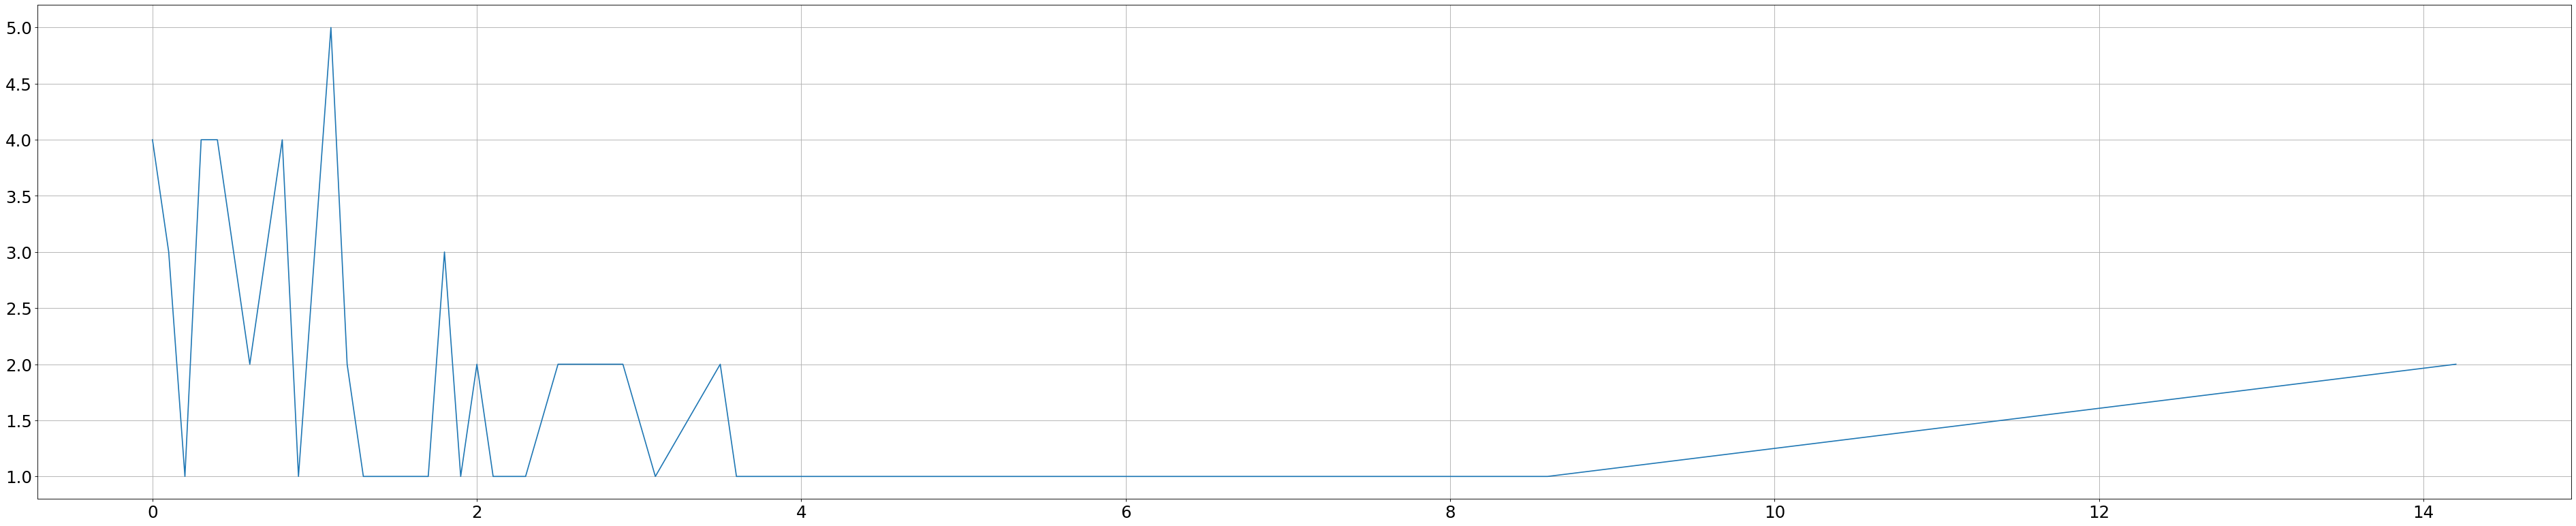

TSLA


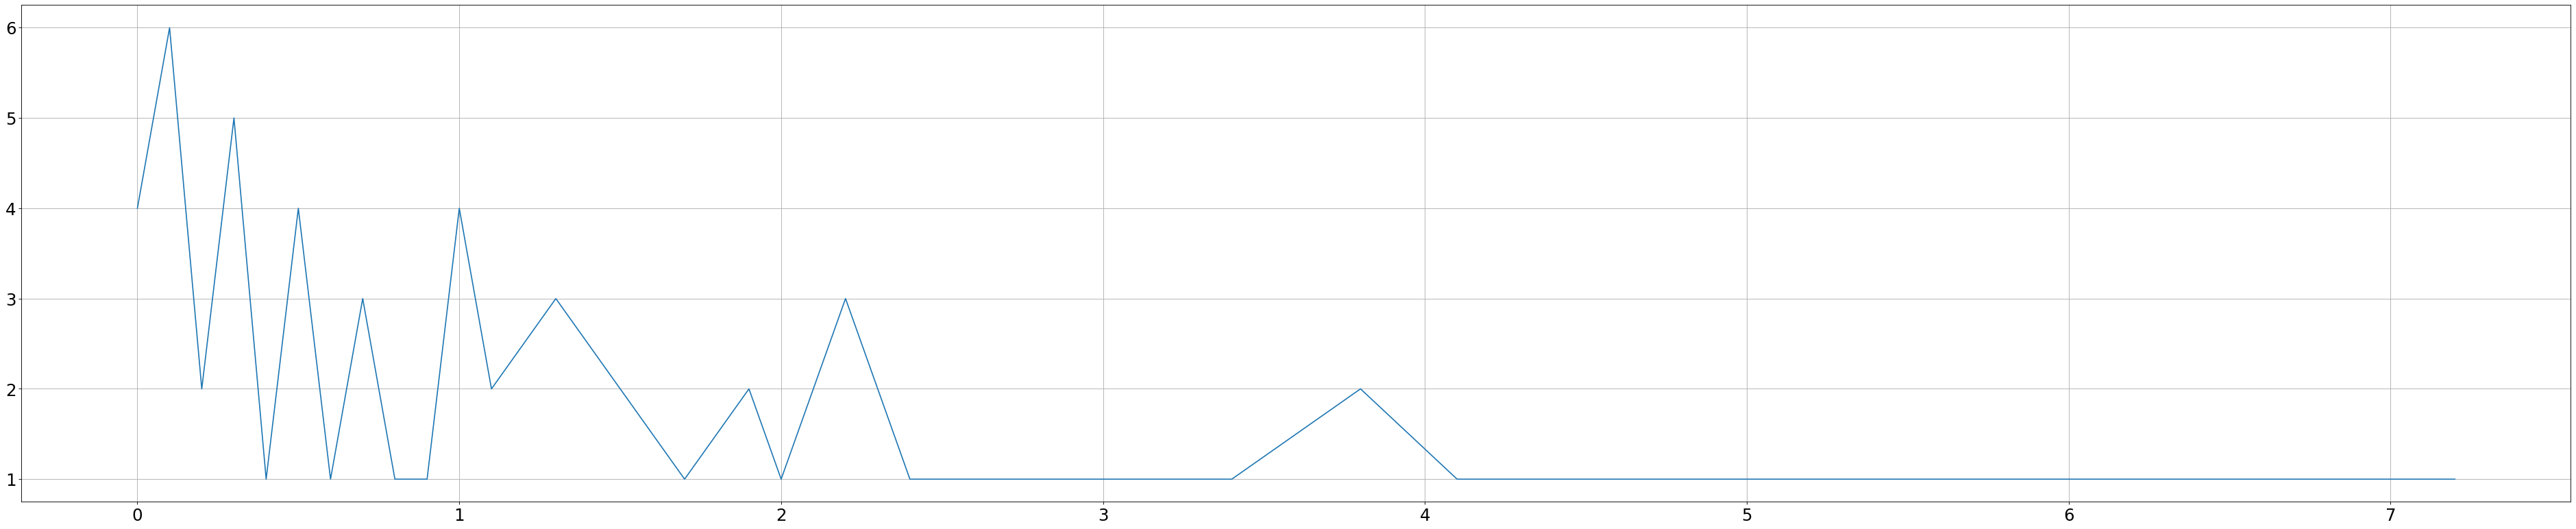

NVDA


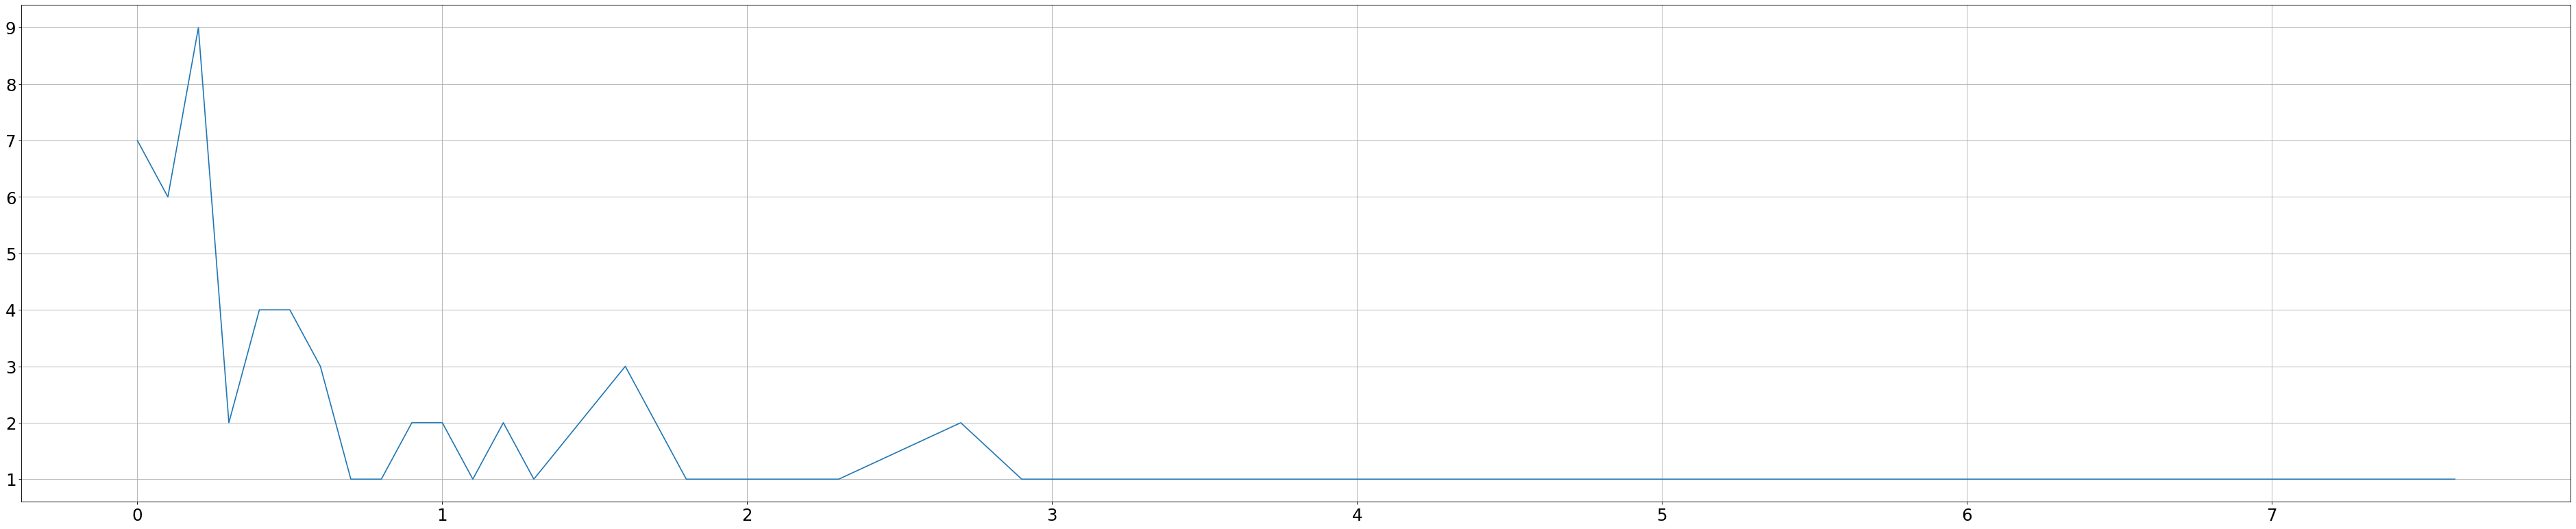

In [97]:
import math
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 22})

# distributions

def round_decimals_down(number:float, decimals:int=1):
    """
    Returns a value rounded down to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.floor(number)

    factor = 10 ** decimals
    return math.floor(number * factor) / factor

profits = {}

for company in companies:
  figi = company["figi"]
  ticker = company["ticker"]

  profits[figi] = {}

  for trade in trades[figi]:
    key = round_decimals_down(trade['run_up'])
    if not profits[figi].get(key):
      profits[figi][key] = 0

    profits[figi][key] += 1

  print(company["ticker"])

  plt.figure(figsize = (60, 12), dpi = 80)
  plt.grid()

  sort = sorted(profits[figi].keys())
  x=list(sort)
  y=list(map(lambda x: profits[figi][x], sort))
  plt.plot(x, y)
  plt.show()

In [101]:
import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objects as go
from functools import reduce

matplotlib.rcParams.update({'font.size': 22})

def frequences(items, ticker):
  more1 = 0
  more04 = 0
  more06 = 0
  more08 = 0

  for item in items:
    if item['run_up'] >= 1:
      more1 += 1
    
    if item['run_up'] >= 0.4:
      more04 += 1

    if item['run_up'] >= 0.6:
      more06 += 1
    
    if item['run_up'] >= 0.8:
      more08 += 1
  
  percent1 = more04 / len(items) * 100
  percent2 = more06 / len(items) * 100
  percent3 = more08 / len(items) * 100
  percent4 = more1 / len(items) * 100

  less04_list = list(filter(lambda x: x['run_up'] < 0.4, items))
  less04_profit = reduce(lambda a, b: a + b['profit'], less04_list, 0)
  
  less06_list = list(filter(lambda x: x['run_up'] < 0.6, items))
  less06_profit = reduce(lambda a, b: a + b['profit'], less06_list, 0)
  
  less08_list = list(filter(lambda x: x['run_up'] < 0.8, items))
  less08_profit = reduce(lambda a, b: a + b['profit'], less08_list, 0)
  
  less1_list = list(filter(lambda x: x['run_up'] < 1, items))
  less1_profit = reduce(lambda a, b: a + b['profit'], less1_list, 0)

  average_less04_profit = round_decimals_down(less04_profit / len(less04_list), 2) if len(less04_list) != 0 else 0
  average_less06_profit = round_decimals_down(less06_profit / len(less06_list), 2) if len(less06_list) != 0 else 0
  average_less08_profit = round_decimals_down(less08_profit / len(less08_list), 2) if len(less08_list) != 0 else 0
  average_less1_profit = round_decimals_down(less1_profit / len(less1_list), 2) if len(less1_list) != 0 else 0

  print(f"""
    ticker: {ticker}
    trades: {len(items)}
    more 0.4% : {round_decimals_down(percent1, 2)}%
    if less than 0.4% then average profit is {average_less04_profit}%. {len(less04_list)} trades
    profit: {round_decimals_down((len(items) - len(less04_list)) * 0.4, 2)}% loss: {round_decimals_down(len(less04_list) * average_less04_profit, 2)}%

    more 0.6% : {round_decimals_down(percent2, 2)}%
    if less than 0.6% then average profit is {average_less06_profit}%. {len(less06_list)} trades
    profit: {round_decimals_down((len(items) - len(less06_list)) * 0.6, 2)}% loss: {round_decimals_down(len(less06_list) * average_less06_profit, 2)}%

    more 0.8% : {round_decimals_down(percent3, 2)}%
    if less than 0.8% then average profit is {average_less08_profit}%. {len(less08_list)} trades
    profit: {round_decimals_down((len(items) - len(less08_list)) * 0.8, 2)}% loss: {round_decimals_down(len(less08_list) * average_less08_profit, 2)}%

    more 1% : {round_decimals_down(percent4, 2)}%
    if less than 1% then average profit is {average_less1_profit}%. {len(less1_list)} trades
    profit: {round_decimals_down((len(items) - len(less1_list)), 2)}% loss: {round_decimals_down(len(less1_list) * average_less1_profit, 2)}%
  """)

print(f"""
periods = {periods}
interval = {interval}
""")

for company in companies:
  figi = company["figi"]
  ticker = company["ticker"]

  filtered = list(filter(lambda x: x['time'].hour >= 16 and x['time'].hour <= 23, trades[figi]))
  # filtered = trades[figi]
  frequences(filtered, ticker)

  x = list(map(lambda q: q['time'].format('DD/MM HH:mm'), filtered))

  fig = go.Figure()
  fig.add_trace(
    go.Bar(
      x=x,
      y=list(map(lambda q: q['run_up'], filtered)),
      name='run up',
      marker_color='green'
    )
  )
  fig.add_trace(
    go.Bar(
      x=x,
      y=list(map(lambda q: q['profit'], filtered)),
      name='profit',
      marker_color='gray'
    )
  )
  fig.update_layout(
    barmode='group',
  )

  fig.show()





periods = 40
interval = 15min


    ticker: MRNA
    trades: 28
    more 0.4% : 100.0%
    if less than 0.4% then average profit is 0%. 0 trades
    profit: 11.2% loss: 0.0%

    more 0.6% : 85.71%
    if less than 0.6% then average profit is -0.32%. 4 trades
    profit: 14.39% loss: -1.28%

    more 0.8% : 82.14%
    if less than 0.8% then average profit is -0.51%. 5 trades
    profit: 18.4% loss: -2.55%

    more 1% : 75.0%
    if less than 1% then average profit is -0.26%. 7 trades
    profit: 21.0% loss: -1.82%
  



    ticker: TSLA
    trades: 26
    more 0.4% : 84.61%
    if less than 0.4% then average profit is -1.12%. 4 trades
    profit: 8.8% loss: -4.49%

    more 0.6% : 76.92%
    if less than 0.6% then average profit is -0.74%. 6 trades
    profit: 12.0% loss: -4.44%

    more 0.8% : 73.07%
    if less than 0.8% then average profit is -0.66%. 7 trades
    profit: 15.2% loss: -4.62%

    more 1% : 69.23%
    if less than 1% then average profit is -1.47%. 8 trades
    profit: 18.0% loss: -11.76%
  



    ticker: NVDA
    trades: 24
    more 0.4% : 66.66%
    if less than 0.4% then average profit is -1.16%. 8 trades
    profit: 6.4% loss: -9.28%

    more 0.6% : 54.16%
    if less than 0.6% then average profit is -1.11%. 11 trades
    profit: 7.8% loss: -12.21%

    more 0.8% : 54.16%
    if less than 0.8% then average profit is -1.11%. 11 trades
    profit: 10.4% loss: -12.21%

    more 1% : 54.16%
    if less than 1% then average profit is -1.11%. 11 trades
    profit: 13.0% loss: -12.21%
  
